# Market Tools Notebook
This notebook provides:
1. **Simple Moving Average (SMA)** visualizations
2. **Upward & Downward Runs** stats + chart markers
3. **Daily Returns** (line + histogram) — using $r_t = \frac{P_t - P_{t-1}}{P_{t-1}}$
4. **Max Profit (LeetCode 122)** — greedy trades and total profit


In [1]:
# === Cell 1: Load data.py ===
import importlib, sys, types
sys.path.append('.')

# If you edit data.py and want a fresh run, re-execute this cell.
import data
importlib.reload(data)

# Pull frames / metadata built by data.py
close_df  = data.close_df      # wide matrix (columns are simple ticker strings)
open_df   = data.open_df if hasattr(data, 'open_df') else data.frames['Open']
high_df   = data.high_df if hasattr(data, 'high_df') else data.frames['High']
low_df    = data.low_df if hasattr(data, 'low_df') else data.frames['Low']
volume_df = data.volume_df if hasattr(data, 'volume_df') else data.frames['Volume']

sectors          = data.sectors
ticker_to_sector = data.ticker_to_sector

print('Loaded tickers:', list(close_df.columns)[:5], '... total:', len(close_df.columns))
display(close_df.head(3))

[*********************100%***********************]  15 of 15 completed
[**********************53%                       ]  8 of 15 completed

[INFO] Index already clean DateTimeIndex and sorted.
[INFO] Raw rows (dates): 753
[INFO] Long table: 11295 rows × 8 cols.
[INFO] No duplicate (Date,Ticker) rows.
[INFO] Stripping time component from 'Date'.
[INFO] No missing values in ['Open', 'High', 'Low', 'Close', 'Volume'] → no forward-fill needed.
[INFO] No remaining missing values in ['Open', 'High', 'Low', 'Close'] → no interpolation needed.
[INFO] Total NaNs after cleaning: 0
[INFO] [Open] No NaNs after pivot.
[INFO] [High] No NaNs after pivot.
[INFO] [Low] No NaNs after pivot.
[INFO] [Close] No NaNs after pivot.
[INFO] [Volume] No NaNs after pivot.


[*********************100%***********************]  15 of 15 completed


[INFO] Index already clean DateTimeIndex and sorted.
[INFO] Raw rows (dates): 753
[INFO] Long table: 11295 rows × 8 cols.
[INFO] No duplicate (Date,Ticker) rows.
[INFO] Stripping time component from 'Date'.
[INFO] No missing values in ['Open', 'High', 'Low', 'Close', 'Volume'] → no forward-fill needed.
[INFO] No remaining missing values in ['Open', 'High', 'Low', 'Close'] → no interpolation needed.
[INFO] Total NaNs after cleaning: 0
[INFO] [Open] No NaNs after pivot.
[INFO] [High] No NaNs after pivot.
[INFO] [Low] No NaNs after pivot.
[INFO] [Close] No NaNs after pivot.
[INFO] [Volume] No NaNs after pivot.
Loaded tickers: ['AAPL', 'MSFT', 'NVDA', 'JPM', 'BAC'] ... total: 15


Ticker,AAPL,MSFT,NVDA,JPM,BAC,MA,JNJ,PFE,ABBV,PEP,MCD,NKE,XOM,SHEL,CVX
Date,,,,,,,,,,,,,,,
2022-09-20,156.899994,242.449997,13.176,115.830002,34.169998,313.269989,164.970001,44.770000,141.770004,168.919998,255.399994,102.419998,92.440002,52.849998,156.279999
2022-09-21,153.720001,238.949997,13.261,112.489998,33.150002,304.500000,163.279999,43.919998,140.309998,168.440002,251.080002,99.790001,90.949997,52.330002,155.009995
2022-09-22,152.740005,240.979996,12.561,111.209999,32.500000,298.359985,166.179993,44.570000,143.009995,168.600006,247.940002,98.550003,90.570000,52.340000,154.889999


In [2]:
# === Cell 2: Utilities ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

def get_close_series(close_df: pd.DataFrame, ticker: str) -> pd.Series:
    """Extract a single ticker's Close price series from a wide DataFrame with simple columns."""
    s = close_df[ticker]
    s.name = ticker
    return s.sort_index()

def sma(series: pd.Series, window: int, min_periods: int | None = None) -> pd.Series:
    """Simple Moving Average for a 1-D Series."""
    return series.rolling(window=window, min_periods=min_periods or window).mean()

def daily_returns(series: pd.Series) -> pd.Series:
    """Simple daily returns r_t = (P_t - P_{t-1}) / P_{t-1}."""
    return series.pct_change()

@dataclass
class RunStats:
    up_runs_count: int
    down_runs_count: int
    up_total_days: int
    down_total_days: int
    longest_up_run: int
    longest_down_run: int

def _runs_from_signs(ret: pd.Series) -> RunStats:
    """Compute run stats from return signs: up (>0), down (<0), flat (=0 breaks runs)."""
    s = ret.copy().fillna(0.0)
    up_runs = down_runs = 0
    up_total = down_total = 0
    longest_up = longest_down = 0
    curr_sign = 0   # 1 up, -1 down, 0 none
    curr_len = 0

    for x in s:
        sign = 1 if x > 0 else (-1 if x < 0 else 0)
        if sign == 0:
            if curr_sign == 1:
                up_runs += 1; up_total += curr_len; longest_up = max(longest_up, curr_len)
            elif curr_sign == -1:
                down_runs += 1; down_total += curr_len; longest_down = max(longest_down, curr_len)
            curr_sign = 0; curr_len = 0
            continue
        if sign == curr_sign:
            curr_len += 1
        else:
            if curr_sign == 1:
                up_runs += 1; up_total += curr_len; longest_up = max(longest_up, curr_len)
            elif curr_sign == -1:
                down_runs += 1; down_total += curr_len; longest_down = max(longest_down, curr_len)
            curr_sign = sign; curr_len = 1
        if curr_sign == 0:
            curr_sign = sign; curr_len = 1

    if curr_len > 0:
        if curr_sign == 1:
            up_runs += 1; up_total += curr_len; longest_up = max(longest_up, curr_len)
        elif curr_sign == -1:
            down_runs += 1; down_total += curr_len; longest_down = max(longest_down, curr_len)

    return RunStats(up_runs, down_runs, up_total, down_total, longest_up, longest_down)

def runs_for_ticker(close_df: pd.DataFrame, ticker: str) -> RunStats:
    ret = daily_returns(get_close_series(close_df, ticker))
    return _runs_from_signs(ret)

def max_profit_buy_sell_ii(series: pd.Series) -> float:
    """LeetCode 122 greedy: sum of all positive day-to-day price changes."""
    s = series.dropna()
    return float(s.diff().clip(lower=0).sum())

def greedy_trades(series: pd.Series):
    """Reconstruct (buy_date, sell_date) pairs realizing the greedy max profit; also return total profit."""
    s = series.dropna()
    idx = s.index
    buys, sells = [], []
    in_pos = False
    buy_i = None
    for i in range(1, len(s)):
        if s.iloc[i] > s.iloc[i-1] and not in_pos:
            buy_i = i-1; in_pos = True
        if in_pos and s.iloc[i] <= s.iloc[i-1]:
            buys.append(idx[buy_i]); sells.append(idx[i-1])
            in_pos = False; buy_i = None
    if in_pos and buy_i is not None:
        buys.append(idx[buy_i]); sells.append(idx[-1])
    profit = float((s.loc[sells].values - s.loc[buys].values).sum()) if buys else 0.0
    return list(zip(buys, sells)), profit


In [3]:
# === Cell 3: Visualizations ===
def plot_sma(close_df: pd.DataFrame, ticker: str, windows=(5, 20), start=None, end=None):
    s = get_close_series(close_df, ticker)
    if start or end: s = s.loc[start:end]
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(s.index, s.values, label=f"{ticker} Close")
    for w in windows:
        ax.plot(s.index, sma(s, w).values, label=f"SMA {w}")
    ax.set_title(f"{ticker} — Close with SMA ({', '.join(map(str, windows))})")
    ax.set_xlabel("Date"); ax.set_ylabel("Price"); ax.grid(True); ax.legend()
    plt.show()

def plot_runs(close_df: pd.DataFrame, ticker: str, start=None, end=None):
    s = get_close_series(close_df, ticker)
    if start or end: s = s.loc[start:end]
    r = daily_returns(s)
    stats = _runs_from_signs(r)
    up_mask = r > 0; down_mask = r < 0

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(s.index, s.values, label=f"{ticker} Close")
    ax.scatter(s.index[up_mask], s[up_mask], marker='^', s=30, label='Up day')
    ax.scatter(s.index[down_mask], s[down_mask], marker='v', s=30, label='Down day')
    ax.set_title(f"{ticker} — Up/Down Runs | Up runs: {stats.up_runs_count} (longest {stats.longest_up_run}), "
                 f"Down runs: {stats.down_runs_count} (longest {stats.longest_down_run})")
    ax.set_xlabel("Date"); ax.set_ylabel("Price"); ax.grid(True); ax.legend()
    plt.show()

def plot_daily_returns_line(close_df: pd.DataFrame, ticker: str, start=None, end=None):
    s = get_close_series(close_df, ticker)
    if start or end: s = s.loc[start:end]
    r = daily_returns(s)
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(r.index, r.values, label='Daily return'); ax.axhline(0.0)
    ax.set_title(f"{ticker} — Daily Returns (r_t = (P_t - P_(t-1))/P_(t-1))")
    ax.set_xlabel("Date"); ax.set_ylabel("Return"); ax.grid(True); ax.legend()
    plt.show()

def plot_daily_returns_hist(close_df: pd.DataFrame, ticker: str, start=None, end=None, bins=50):
    s = get_close_series(close_df, ticker)
    if start or end: s = s.loc[start:end]
    r = daily_returns(s).dropna()
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.hist(r.values, bins=bins)
    ax.set_title(f"{ticker} — Daily Return Distribution")
    ax.set_xlabel("Return"); ax.set_ylabel("Frequency"); ax.grid(True)
    plt.show()

def plot_max_profit_trades(close_df: pd.DataFrame, ticker: str, start=None, end=None):
    s = get_close_series(close_df, ticker)
    if start or end: s = s.loc[start:end]
    trades, profit = greedy_trades(s)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(s.index, s.values, label=f"{ticker} Close")
    if trades:
        buy_idx = [b for b,_ in trades]; sell_idx = [e for _,e in trades]
        ax.scatter(buy_idx, s.loc[buy_idx], marker='^', s=60, label='Buy')
        ax.scatter(sell_idx, s.loc[sell_idx], marker='v', s=60, label='Sell')
    ax.set_title(f"{ticker} — Greedy Trades (Max Profit II: {profit:,.2f})")
    ax.set_xlabel("Date"); ax.set_ylabel("Price"); ax.grid(True); ax.legend()
    plt.show()


In [4]:
# === Cell 4: Summaries (tables) ===
def runs_summary_all(close_df: pd.DataFrame, ticker_to_sector: dict[str, str]) -> pd.DataFrame:
    rows = []
    for t in close_df.columns:
        s = close_df[t]
        st = _runs_from_signs(s.pct_change())
        rows.append({
            'Ticker': t,
            'Sector': ticker_to_sector.get(t, 'Unknown'),
            'UpRuns': st.up_runs_count,
            'DownRuns': st.down_runs_count,
            'UpDaysTotal': st.up_total_days,
            'DownDaysTotal': st.down_total_days,
            'LongestUp': st.longest_up_run,
            'LongestDown': st.longest_down_run,
        })
    return pd.DataFrame(rows).set_index('Ticker').sort_index()

def max_profit_all(close_df: pd.DataFrame, ticker_to_sector: dict[str, str]) -> pd.DataFrame:
    rows = []
    for t in close_df.columns:
        s = close_df[t]
        prof = max_profit_buy_sell_ii(s)
        rows.append({'Ticker': t, 'Sector': ticker_to_sector.get(t, 'Unknown'), 'Profit': prof})
    return pd.DataFrame(rows).set_index('Ticker').sort_values('Profit', ascending=False)

# Preview summaries
display(runs_summary_all(close_df, ticker_to_sector).head())
display(max_profit_all(close_df, ticker_to_sector).head())

,Sector,UpRuns,DownRuns,UpDaysTotal,DownDaysTotal,LongestUp,LongestDown
Ticker,,,,,,,
AAPL,Tech,182,182,404,346,8,8
ABBV,Healthcare,181,180,403,348,12,8
BAC,Finance,169,168,385,362,8,8
CVX,Energy,176,177,405,347,9,8
JNJ,Healthcare,170,170,391,359,9,10


,Sector,Profit
Ticker,,
MSFT,Tech,1655.914963
MA,Finance,1639.500336
AAPL,Tech,898.424995
MCD,Consumer Goods,868.809952
JPM,Finance,838.950012


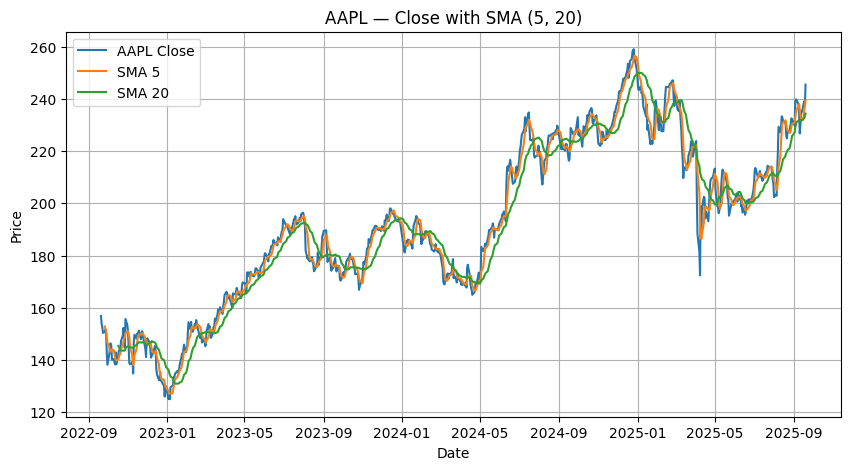

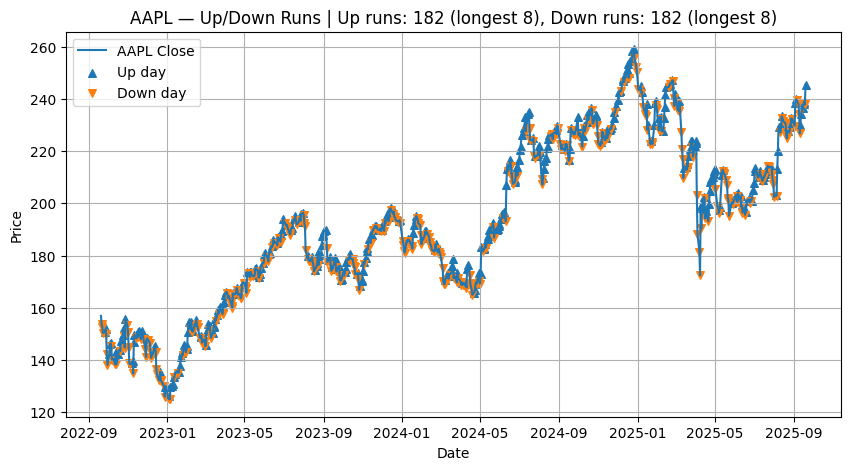

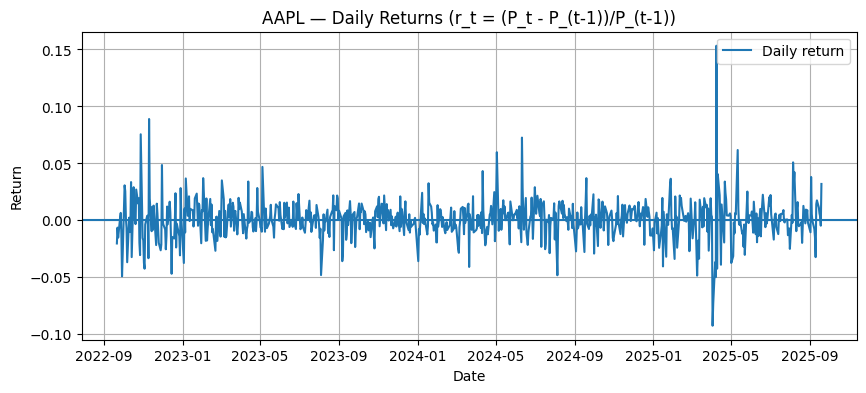

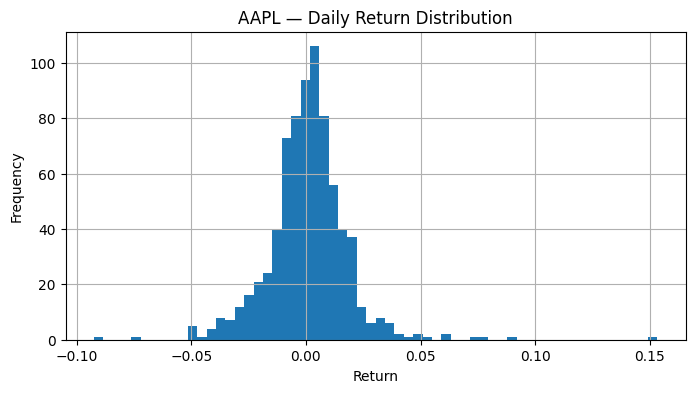

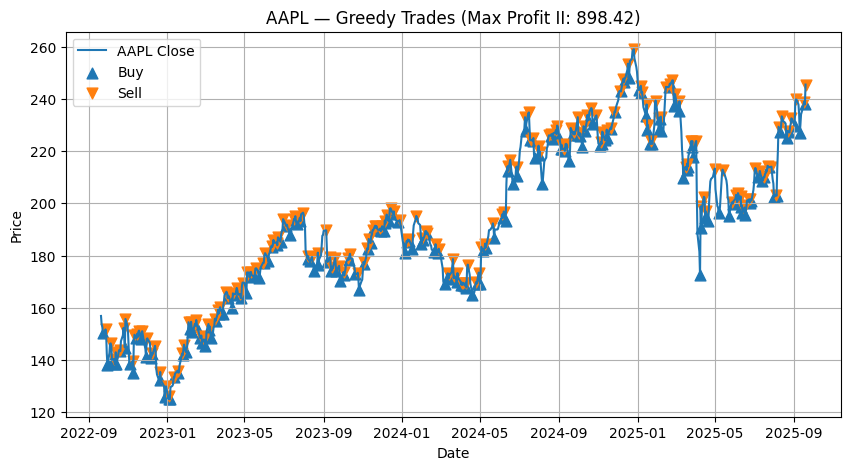

In [5]:
# === Cell 5: Demo usage ===
ticker = 'AAPL'
start = None   # e.g., '2024-01-01'
end   = None   # e.g., '2024-12-31'

# 1) SMA overlays
plot_sma(close_df, ticker, windows=(5, 20), start=start, end=end)

# 2) Up/Down run markers + title with stats
plot_runs(close_df, ticker, start=start, end=end)

# 3) Daily returns (line + histogram)
plot_daily_returns_line(close_df, ticker, start=start, end=end)
plot_daily_returns_hist(close_df, ticker, start=start, end=end, bins=60)

# 4) Max Profit II with buy/sell markers
plot_max_profit_trades(close_df, ticker, start=start, end=end)